# Melakukan Klasifikasi Penyakit Alzeimer dengan Algoritma `Xgboost` dan `KNN`

In [1]:
!pip install xgboost imblearn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from imblearn.over_sampling import SMOTE

import xgboost as xgb

## 1. Data Exploration

### Read the dataset

Data ini memiliki kolom primary key yaitu `PatientID`, memiliki kolom diskrit seperti `Gender`, `Ethnicity`, `EducationLevel`, `dll`, serta kolom continuous seperti `Age`, `BMI`, dan `AlchoholConsumption`

In [5]:
df = pd.read_csv('alzheimers_disease_data.csv')
df = df.drop(['DoctorInCharge', 'PatientID'], axis=1)
df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


### Explore Kolom-Kolom

Tidak ada kolom dengan value `null`. Semua kolom memiliki value.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64

### Statistical Summaries

In [7]:
df.describe()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,7.051081,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,1.763573,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,4.002629,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,5.482997,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,7.115646,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,8.562521,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,9.999840,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Membagi dataset Menjadi `X` dan `y`, serta membaginya juga menjadi dataset `training` dan dataset `testing`

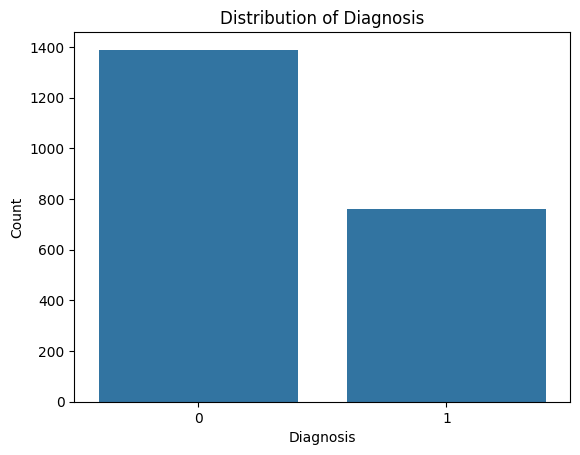

In [9]:
grouped_diagnosis = df['Diagnosis'].value_counts().rename_axis('Diagnosis').reset_index(name='Count')

sns.barplot(x='Diagnosis', y='Count', data=grouped_diagnosis)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Distribution of Diagnosis')
plt.show()

In [10]:
correlation_matrix = df.corr()
correlation_melted = correlation_matrix.reset_index().melt(id_vars='index')
correlation_melted.columns = ['Variable1', 'Variable2', 'Correlation']

alt.Chart(correlation_melted).mark_rect().encode(
    x='Variable1:O',
    y='Variable2:O',
    color='Correlation:Q',
    tooltip=['Variable1', 'Variable2', 'Correlation']
).properties(
    width=420,
    height=420,
    title='Correlation Heatmap'
).interactive()

alt.Chart(...)

In [11]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

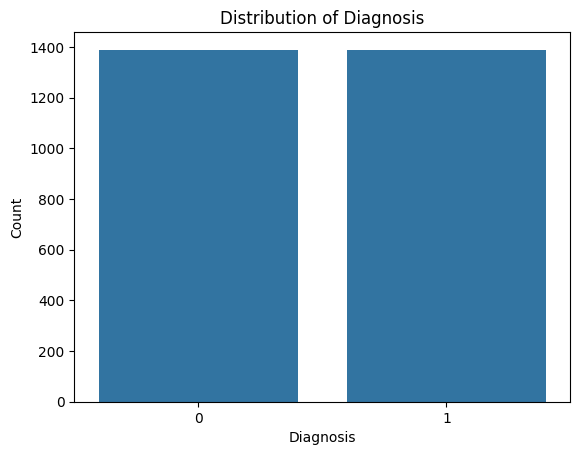

In [12]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled_df = pd.DataFrame(X_resampled, columns=X_resampled.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['Diagnosis'])

new_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

balanced_df = new_df['Diagnosis'].value_counts().rename_axis('Diagnosis').reset_index(name='Count')

sns.barplot(x='Diagnosis', y='Count', data=balanced_df)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Distribution of Diagnosis')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42, test_size=0.2)

### Normalisasi

Tujuannya yaitu supaya bobot masing-masing kolom memiliki skala yang sama, sehingga bias dapat dihindari.

Pada **KNN** misalnya, skala sangat penting karena **KNN** menggunakan jarak sebagai perhitungan.

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
X_train_scaled

array([[-0.21685097,  1.11250332,  1.43674017, ...,  2.72335577,
        -0.38666334, -0.57492514],
       [ 0.01358559, -0.89887372,  0.37929179, ..., -0.36719404,
        -0.38666334, -0.57492514],
       [-0.33206926, -0.89887372, -0.67815659, ...,  2.72335577,
        -0.38666334,  1.73935687],
       ...,
       [ 1.16576844, -0.89887372,  0.37929179, ..., -0.36719404,
        -0.38666334, -0.57492514],
       [ 1.62664157,  1.11250332, -0.67815659, ..., -0.36719404,
        -0.38666334, -0.57492514],
       [-0.44728754, -0.89887372,  1.43674017, ..., -0.36719404,
        -0.38666334, -0.57492514]])

In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

## 2. Model Construction

In [18]:
neighbors = 7

### Building Models

Model yang akan dibuat disini adalah **XgBoost** dan **KNN (K Nearest Neighbors)**

In [19]:
xgb_model = xgb.XGBClassifier()

# Parameter Grid
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 0.9189894347789084


In [20]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [i for i in range(3, 100, 2)]
}

knn_grid_search = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid, cv=3, scoring='accuracy', verbose=1)
knn_grid_search.fit(X_train_scaled, y_train)

print("Best Params:", knn_grid_search.best_params_)
print("Best Score:", knn_grid_search.best_score_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
Best Params: {'n_neighbors': 7}
Best Score: 0.722320093372725


In [23]:
models = {
    "XGBoost": xgb.XGBClassifier(
        colsample_bytree=grid_search.best_params_['colsample_bytree'],
        learning_rate=grid_search.best_params_['learning_rate'],
        max_depth=grid_search.best_params_['max_depth'],
        n_estimators=grid_search.best_params_['n_estimators'],
        subsample=grid_search.best_params_['subsample']),
    "KNN": KNeighborsClassifier(n_neighbors=knn_grid_search.best_params_['n_neighbors']),
}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)

## 3. Model Evaluation

In [24]:
def display_confusion_matrix(y_test, y_pred, model):
    cm = confusion_matrix(
        y_test, y_pred,
        labels=model.classes_
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.show()

In [25]:
y_pred = {}
y_pred['XGBoost'] = models['XGBoost'].predict(X_test_scaled)
y_pred['KNN'] = models['KNN'].predict(X_test_scaled)

In [26]:
def altair_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['False', 'True'], columns=['False', 'True'])
    cm_df = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
    cm_df.rename(columns={'index': 'Actual'}, inplace=True)

    heatmap = alt.Chart(cm_df, height=400, width=400).mark_rect().encode(
        x=alt.X('Predicted:N', title='Predicted Label', axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelAngle=0)),
        y=alt.Y('Actual:N', title='Actual Label', axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
        color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues'), title='Count'),
        tooltip=[alt.Tooltip('Actual:N'), alt.Tooltip('Predicted:N'), alt.Tooltip('Count:Q')]
    ).properties(
        title=f'Confusion Matrix Heatmap of {model_name} (True vs False)'
    )

    text_annotations = heatmap.mark_text(
        align='center',
        baseline='middle',
        fontSize=20,
    ).encode(
        color=alt.value('black'),
        text='Count:Q'
    )

    return heatmap + text_annotations

### Confusion Matrix

In [27]:
cm_xgb = altair_confusion_matrix(y_test, y_pred['XGBoost'], 'XGBoost')
cm_knn = altair_confusion_matrix(y_test, y_pred['KNN'], 'KNN')

alt.hconcat(cm_xgb, cm_knn)

alt.HConcatChart(...)

#### Evaluation Model Report

In [28]:
def evaluate_model_report(y_test, y_pred, model_name):
  accuracy = "{:.2f}%".format(round(accuracy_score(y_test, y_pred) * 100, 2))
  print(f'Accuracy score of {model_name}: {accuracy}')
  print(classification_report(y_test, y_pred))

In [29]:
xgboost_predictions = models['XGBoost'].predict(X_test)
knn_predictions = models['KNN'].predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [30]:
for key, value in models.items():
    evaluate_model_report(y_test, y_pred[key], key)

Accuracy score of XGBoost: 90.83%
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       273
           1       0.96      0.86      0.91       283

    accuracy                           0.91       556
   macro avg       0.91      0.91      0.91       556
weighted avg       0.91      0.91      0.91       556

Accuracy score of KNN: 74.46%
              precision    recall  f1-score   support

           0       0.84      0.59      0.69       273
           1       0.69      0.89      0.78       283

    accuracy                           0.74       556
   macro avg       0.77      0.74      0.74       556
weighted avg       0.77      0.74      0.74       556



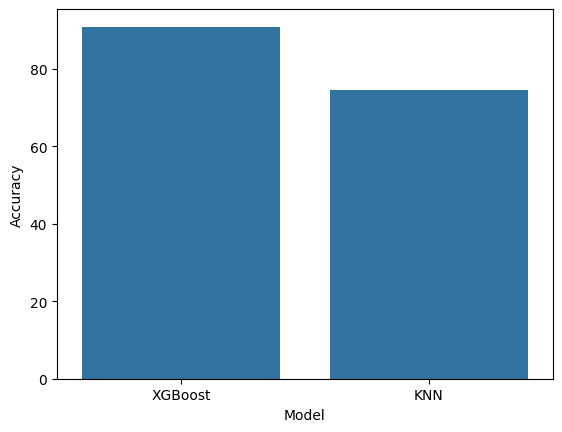

In [35]:
xgb_accuracy = "{:.2f}".format(round(accuracy_score(y_test, y_pred['XGBoost']) * 100, 2))
knn_accuracy = "{:.2f}".format(round(accuracy_score(y_test, y_pred['KNN']) * 100, 2))

results_df = pd.DataFrame(
    {
        'Model': ['XGBoost', 'KNN'],
        'Accuracy': [float(xgb_accuracy), float(knn_accuracy)]
    }
)

sns.barplot(results_df, x='Model', y='Accuracy')
plt.show()

## 5. Kesimpulan

Xgboost memiliki performa yang lebih baik dari KNN dengan mendapatkan akurasi sekitar 91%, sedangkan KNN hanya mendapatkan akurasi tertinggi sekitar 74%.